In [1]:
# Import numpy first
import numpy as np

# Then import TensorFlow
import tensorflow as tf

# Then other keras imports
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Dense, Dropout, GlobalAveragePooling2D, 
                                   LSTM, TimeDistributed, Input, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l1_l2

# Other essential imports
import cv2
import os
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
### CELL 2: CONFIGURATION SETTINGS ###
# Configure your exact data path here
DATA_DIR = r"C:\Users\Lenovo\Downloads\ISL Model\Indian"  
IMG_SIZE = 224
SEQUENCE_LENGTH = 10  # Number of frames per sequence
NUM_CLASSES = 36      # 0-9 and A-Z
BATCH_SIZE = 8        # Optimized batch size (reduced for memory)
VALIDATION_SPLIT = 0.25  # 25% for validation (improved from 10%)
TEST_SPLIT = 0.15     # 15% for final testing
EPOCHS = 30          # More epochs with early stopping

# Verify data directory exists
if os.path.exists(DATA_DIR):
    print(f"✅ Data directory confirmed: {DATA_DIR}")
    sample_classes = os.listdir(DATA_DIR)[:5]
    print(f"📁 Sample classes found: {sample_classes}")
else:
    print(f"❌ ERROR: Data directory not found: {DATA_DIR}")
    print("Please update DATA_DIR to your correct path!")

print(f"\n📊 Configuration Summary:")
print(f"   • Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   • Sequence length: {SEQUENCE_LENGTH} frames")
print(f"   • Batch size: {BATCH_SIZE}")
print(f"   • Validation split: {VALIDATION_SPLIT*100}%")
print(f"   • Test split: {TEST_SPLIT*100}%")

✅ Data directory confirmed: C:\Users\Lenovo\Downloads\ISL Model\Indian
📁 Sample classes found: ['0', '1', '2', '3', '4']

📊 Configuration Summary:
   • Image size: 224x224
   • Sequence length: 10 frames
   • Batch size: 8
   • Validation split: 25.0%
   • Test split: 15.0%


In [3]:
### CELL 3: ENHANCED DATA GENERATOR CLASS ###
class ImprovedGestureGenerator(Sequence):
    """Enhanced data generator with augmentation and proper handling"""

    def __init__(self, sequences, batch_size=6, sequence_length=10, 
                 img_size=224, shuffle=True, augment=False):
        self.sequences = sequences
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

        print(f"📊 Generator created: {len(self.sequences)} sequences")
        print(f"   • Batch size: {self.batch_size}")
        print(f"   • Augmentation: {self.augment}")

    def __len__(self):
        return len(self.sequences) // self.batch_size

    def __getitem__(self, index):
        batch_sequences = self.sequences[index * self.batch_size:(index + 1) * self.batch_size]

        X = np.zeros((self.batch_size, self.sequence_length, self.img_size, self.img_size, 3))
        y = np.zeros((self.batch_size,))

        for i, (sequence_paths, label) in enumerate(batch_sequences):
            for j, img_path in enumerate(sequence_paths):
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Proper color conversion
                        img = cv2.resize(img, (self.img_size, self.img_size))

                        # Apply augmentation only during training
                        if self.augment:
                            img = self._augment_image(img)

                        img = img.astype('float32') / 255.0  # Normalize to [0,1]
                        X[i, j] = img
                    else:
                        print(f"⚠️  Failed to load image: {img_path}")
                        X[i, j] = np.zeros((self.img_size, self.img_size, 3))
                except Exception as e:
                    print(f"⚠️  Error loading {img_path}: {e}")
                    X[i, j] = np.zeros((self.img_size, self.img_size, 3))
            y[i] = label

        return X, y

    def _augment_image(self, img):
        """Apply random augmentation - careful with gesture meaning"""
        # Random brightness (±12%)
        if random.random() > 0.6:
            brightness = random.uniform(0.88, 1.12)
            img = np.clip(img * brightness, 0, 255).astype(np.uint8)

        # Small rotation (±6 degrees)
        if random.random() > 0.7:
            angle = random.uniform(-6, 6)
            center = (self.img_size // 2, self.img_size // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
            img = cv2.warpAffine(img, rotation_matrix, (self.img_size, self.img_size))

        # Small gaussian noise
        if random.random() > 0.8:
            noise = np.random.normal(0, 2, img.shape).astype(np.uint8)
            img = np.clip(img + noise, 0, 255).astype(np.uint8)

        return img

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.sequences)

print("✅ Enhanced data generator class defined!")


✅ Enhanced data generator class defined!


In [4]:
### CELL 4: PROPER DATA SPLITTING FUNCTION ###
def create_better_data_splits():
    """Create proper train/validation/test splits without data leakage"""
    print("🔄 Creating improved data splits...")

    # Get gesture classes
    gesture_classes = sorted([d for d in os.listdir(DATA_DIR) 
                             if os.path.isdir(os.path.join(DATA_DIR, d))])
    class_to_idx = {cls: idx for idx, cls in enumerate(gesture_classes)}

    print(f"📁 Found {len(gesture_classes)} gesture classes")
    print(f"   First 5 classes: {gesture_classes[:5]}")

    all_sequences = []

    # Process each class separately to ensure balanced splits
    for i, gesture_class in enumerate(gesture_classes):
        class_path = os.path.join(DATA_DIR, gesture_class)
        images = sorted([f for f in os.listdir(class_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

        print(f"   Processing {gesture_class}: {len(images)} images", end="")

        # Create sequences with reduced overlap (every 4th instead of every 5th)
        class_sequences = []
        for seq_start in range(len(images) - SEQUENCE_LENGTH + 1):
            if seq_start % 20 == 0:  # Less overlap = less data leakage
                sequence_paths = []
                for frame_idx in range(SEQUENCE_LENGTH):
                    img_path = os.path.join(class_path, images[seq_start + frame_idx])
                    sequence_paths.append(img_path)
                class_sequences.append((sequence_paths, class_to_idx[gesture_class]))

        print(f" → {len(class_sequences)} sequences")

        # Split this class's sequences
        if len(class_sequences) >= 12:  # Ensure minimum sequences per split
            train_seq, temp_seq = train_test_split(
                class_sequences, 
                test_size=(VALIDATION_SPLIT + TEST_SPLIT), 
                random_state=42, 
                shuffle=True
            )
            val_seq, test_seq = train_test_split(
                temp_seq, 
                test_size=(TEST_SPLIT / (VALIDATION_SPLIT + TEST_SPLIT)), 
                random_state=42
            )

            all_sequences.extend([
                ('train', train_seq),
                ('validation', val_seq),
                ('test', test_seq)
            ])
        else:
            print(f"⚠️  Class {gesture_class} has too few sequences ({len(class_sequences)}), skipping")

    # Combine all sequences by type
    train_sequences = []
    val_sequences = []
    test_sequences = []

    for split_type, sequences in all_sequences:
        if split_type == 'train':
            train_sequences.extend(sequences)
        elif split_type == 'validation':
            val_sequences.extend(sequences)
        else:
            test_sequences.extend(sequences)

    # Final shuffle
    np.random.shuffle(train_sequences)
    np.random.shuffle(val_sequences)
    np.random.shuffle(test_sequences)

    total_seqs = len(train_sequences) + len(val_sequences) + len(test_sequences)
    print(f"\n✅ Data split complete:")
    print(f"   📊 Training: {len(train_sequences)} sequences ({len(train_sequences)/total_seqs*100:.1f}%)")
    print(f"   📊 Validation: {len(val_sequences)} sequences ({len(val_sequences)/total_seqs*100:.1f}%)")
    print(f"   📊 Test: {len(test_sequences)} sequences ({len(test_sequences)/total_seqs*100:.1f}%)")

    return train_sequences, val_sequences, test_sequences, gesture_classes

print("✅ Data splitting function defined!")

✅ Data splitting function defined!


In [5]:
### CELL 5: RUN DATA SPLITTING ###
# Execute the data splitting
train_sequences, val_sequences, test_sequences, gesture_classes = create_better_data_splits()

# Show some statistics
print(f"\n📈 Dataset Statistics:")
print(f"   • Total classes: {len(gesture_classes)}")
print(f"   • Classes: {gesture_classes}")
print(f"   • Training sequences: {len(train_sequences)}")
print(f"   • Validation sequences: {len(val_sequences)}")
print(f"   • Test sequences: {len(test_sequences)}")

# Verify no data leakage by checking sequence paths
sample_train_path = train_sequences[0][0][0] if train_sequences else "N/A"
sample_val_path = val_sequences[0][0][0] if val_sequences else "N/A"
print(f"\n🔍 Sample paths (to verify split):")
print(f"   • Train: {sample_train_path}")
print(f"   • Val: {sample_val_path}")

🔄 Creating improved data splits...
📁 Found 36 gesture classes
   First 5 classes: ['0', '1', '2', '3', '4']
   Processing 0: 1500 images → 75 sequences
   Processing 1: 1200 images → 60 sequences
   Processing 2: 1200 images → 60 sequences
   Processing 3: 1200 images → 60 sequences
   Processing 4: 1200 images → 60 sequences
   Processing 5: 1200 images → 60 sequences
   Processing 6: 1200 images → 60 sequences
   Processing 7: 1200 images → 60 sequences
   Processing 8: 1200 images → 60 sequences
   Processing 9: 1200 images → 60 sequences
   Processing A: 1200 images → 60 sequences
   Processing B: 1200 images → 60 sequences
   Processing C: 1447 images → 72 sequences
   Processing D: 1200 images → 60 sequences
   Processing E: 1200 images → 60 sequences
   Processing F: 1200 images → 60 sequences
   Processing G: 1200 images → 60 sequences
   Processing H: 1200 images → 60 sequences
   Processing I: 1379 images → 69 sequences
   Processing J: 1200 images → 60 sequences
   Processin

In [6]:
### CELL 6: REGULARIZED MODEL ARCHITECTURE (FIXED) ###
def create_regularized_model():
    """Create CNN-LSTM with heavy regularization to prevent overfitting"""
    print("🏗️  Building regularized CNN-LSTM model...")
    
    # Input layer
    input_layer = Input(shape=(SEQUENCE_LENGTH, IMG_SIZE, IMG_SIZE, 3))
    
    # Improved CNN feature extractor
    base_model = MobileNetV2(
        weights='imagenet', 
        include_top=False, 
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    
    # Freeze most layers, fine-tune only top layers
    base_model.trainable = False
    trainable_count = 0
    for layer in base_model.layers[-8:]:  # Fine-tune last 8 layers
        layer.trainable = True
        trainable_count += 1
    
    print(f"   • MobileNetV2 loaded: {len(base_model.layers)} layers")
    print(f"   • Fine-tuning last {trainable_count} layers")
    
    # CNN model with regularization
    cnn_model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        Dropout(0.5),  # Increased dropout
        Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
        Dropout(0.4)
    ])
    
    # Apply CNN to each frame
    features = TimeDistributed(cnn_model)(input_layer)
    
    # LSTM layers with heavy regularization
    lstm_out = LSTM(
        96,  # Reduced units
        return_sequences=True,
        dropout=0.4,
        recurrent_dropout=0.4,
        kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)
    )(features)
    lstm_out = BatchNormalization()(lstm_out)
    
    lstm_out = LSTM(
        48,  # Further reduced
        dropout=0.4,
        recurrent_dropout=0.3,
        kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)
    )(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)
    
    # Classification layers with heavy dropout
    x = Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(lstm_out)
    x = Dropout(0.6)(x)  # Heavy dropout before final layer
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=predictions)
    
    # Count parameters - FIXED for newer TensorFlow versions
    try:
        # Method 1: Use model.count_params() (TensorFlow 2.x)
        total_params = model.count_params()
        
        # Calculate trainable vs non-trainable
        trainable_params = 0
        non_trainable_params = 0
        
        for layer in model.layers:
            if hasattr(layer, 'count_params'):
                if layer.trainable:
                    trainable_params += layer.count_params()
                else:
                    non_trainable_params += layer.count_params()
        
        # Alternative calculation method
        if trainable_params == 0:
            trainable_params = sum([np.prod(var.shape.as_list()) for var in model.trainable_variables])
            non_trainable_params = sum([np.prod(var.shape.as_list()) for var in model.non_trainable_variables])
    
    except Exception as e:
        print(f"   ⚠️  Could not count parameters: {e}")
        total_params = "Unknown"
        trainable_params = "Unknown"
        non_trainable_params = "Unknown"
    
    print(f"   • Trainable parameters: {trainable_params:,}" if isinstance(trainable_params, int) else f"   • Trainable parameters: {trainable_params}")
    print(f"   • Non-trainable parameters: {non_trainable_params:,}" if isinstance(non_trainable_params, int) else f"   • Non-trainable parameters: {non_trainable_params}")
    print(f"   • Total parameters: {total_params:,}" if isinstance(total_params, int) else f"   • Total parameters: {total_params}")
    
    return model

# Create the model
model = create_regularized_model()
print("✅ Model architecture created with heavy regularization!")


🏗️  Building regularized CNN-LSTM model...
   • MobileNetV2 loaded: 154 layers
   • Fine-tuning last 8 layers
   • Trainable parameters: 2,744,228
   • Non-trainable parameters: 0
   • Total parameters: 2,744,228
✅ Model architecture created with heavy regularization!


In [7]:
### CELL 7: MODEL SUMMARY AND COMPILATION ###
# Display model summary
print("📊 MODEL ARCHITECTURE SUMMARY:")
model.summary()

# Compile with conservative learning rate
print("\n⚙️  Compiling model...")
model.compile(
    optimizer=Adam(
        learning_rate=3e-5,  # Lower learning rate
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model compiled successfully!")
print(f"   • Optimizer: Adam (lr=3e-5)")
print(f"   • Loss: sparse_categorical_crossentropy")
print(f"   • Metrics: accuracy")

📊 MODEL ARCHITECTURE SUMMARY:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 10, 224, 224, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 10, 128)             │       2,623,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 10, 96)              │          86,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 10, 96)              │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 48)                  │          27,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 48)                  │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 36)                  │           2,340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,744,228 (10.47 MB)

 Trainable params: 1,213,956 (4.63 MB)

 Non-trainable params: 1,530,272 (5.84 MB)


⚙️  Compiling model...
✅ Model compiled successfully!
   • Optimizer: Adam (lr=3e-5)
   • Loss: sparse_categorical_crossentropy
   • Metrics: accuracy


In [8]:
### CELL 8: TRAINING CALLBACKS SETUP ###
# Enhanced callbacks for overfitting prevention
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=8,  # More patience
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,  # More aggressive reduction
        patience=3,
        min_lr=1e-8,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_gesture_model_v2.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )
]

print("✅ Training callbacks configured:")
print("   • Early Stopping: patience=10, monitor=val_loss")
print("   • Learning Rate Reduction: factor=0.2, patience=5")
print("   • Model Checkpoint: save_best_only=True")


✅ Training callbacks configured:
   • Early Stopping: patience=10, monitor=val_loss
   • Learning Rate Reduction: factor=0.2, patience=5
   • Model Checkpoint: save_best_only=True


In [9]:
### CELL 9: CREATE DATA GENERATORS ###
# Create data generators
print("🔄 Creating data generators...")

train_generator = ImprovedGestureGenerator(
    train_sequences, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    augment=True  # Enable augmentation for training
)

val_generator = ImprovedGestureGenerator(
    val_sequences, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    augment=False  # No augmentation for validation
)

test_generator = ImprovedGestureGenerator(
    test_sequences, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    augment=False  # No augmentation for testing
)

print(f"✅ Data generators created:")
print(f"   • Training batches: {len(train_generator)}")
print(f"   • Validation batches: {len(val_generator)}")
print(f"   • Test batches: {len(test_generator)}")

🔄 Creating data generators...
📊 Generator created: 1326 sequences
   • Batch size: 8
   • Augmentation: True
📊 Generator created: 552 sequences
   • Batch size: 8
   • Augmentation: False
📊 Generator created: 334 sequences
   • Batch size: 8
   • Augmentation: False
✅ Data generators created:
   • Training batches: 165
   • Validation batches: 69
   • Test batches: 41


In [10]:
### CELL 10: START TRAINING ###
print("🚀 STARTING TRAINING...")
print("=" * 50)

# Start training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ TRAINING COMPLETED!")

🚀 STARTING TRAINING...


C:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0267 - loss: 4.4189
Epoch 1: val_loss improved from inf to 3.79792, saving model to best_gesture_model_v2.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - accuracy: 0.0267 - loss: 4.4188 - val_accuracy: 0.0743 - val_loss: 3.7979 - learning_rate: 3.0000e-05
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0275 - loss: 4.3772
Epoch 2: val_loss improved from 3.79792 to 3.56384, saving model to best_gesture_model_v2.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.0275 - loss: 4.3768 - val_accuracy: 0.0960 - val_loss: 3.5638 - learning_rate: 3.0000e-05
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0379 - loss: 4.2822
Epoch 3: val_loss improved from 3.56384 to 3.29573, saving model to best_gesture_model_v2.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 416s 3s/step - accuracy: 0.0379 - loss: 4.2819 - val_accuracy: 0.1630 - val_loss: 3.2957 - learning_rate: 3.0000e-05
Epoch 4/30
165/165 ━━━━

Epoch 22/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1536 - loss: 3.3817
Epoch 22: val_loss improved from 1.98604 to 1.91767, saving model to best_gesture_model_v2.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 598s 4s/step - accuracy: 0.1536 - loss: 3.3817 - val_accuracy: 0.7971 - val_loss: 1.9177 - learning_rate: 3.0000e-05
Epoch 23/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1428 - loss: 3.3997
Epoch 23: val_loss improved from 1.91767 to 1.86184, saving model to best_gesture_model_v2.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.1428 - loss: 3.3998 - val_accuracy: 0.8134 - val_loss: 1.8618 - learning_rate: 3.0000e-05
Epoch 24/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1514 - loss: 3.3734
Epoch 24: val_loss improved from 1.86184 to 1.83439, saving model to best_gesture_model_v2.keras
165/165 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.1513 - loss: 3.3735 - val_accuracy: 0.8261 - val_loss: 1.8344 - learning_rate: 3.0000e-05
Epoch 25/30
1

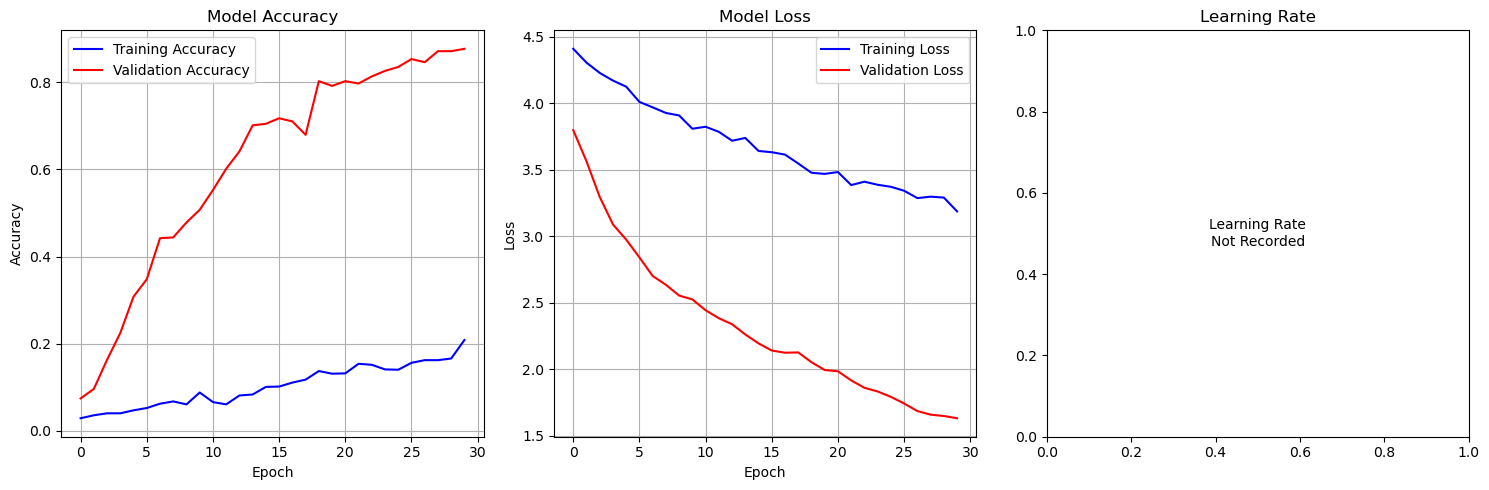


📊 FINAL TRAINING METRICS:
   • Final Training Accuracy: 0.2083 (20.83%)
   • Final Validation Accuracy: 0.8768 (87.68%)
   • Final Training Loss: 3.1873
   • Final Validation Loss: 1.6332


In [11]:
### CELL 11: PLOT TRAINING HISTORY ###
# Plot training history
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot learning rate (if available)
plt.subplot(1, 3, 3)
if 'lr' in history.history:
    plt.plot(history.history['lr'], label='Learning Rate', color='green')
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
else:
    plt.text(0.5, 0.5, 'Learning Rate\nNot Recorded', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Learning Rate')

plt.tight_layout()
plt.show()

# Print final training metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📊 FINAL TRAINING METRICS:")
print(f"   • Final Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"   • Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"   • Final Training Loss: {final_train_loss:.4f}")
print(f"   • Final Validation Loss: {final_val_loss:.4f}")

In [12]:
### CELL 12: EVALUATE ON TEST SET ###
print("\n📈 EVALUATING ON TEST SET...")
print("=" * 30)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"\n🎯 FINAL TEST RESULTS:")
print(f"   • Test Loss: {test_loss:.4f}")
print(f"   • Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Compare all metrics
print(f"\n📊 COMPREHENSIVE RESULTS COMPARISON:")
print(f"   • Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"   • Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"   • Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   • Training Loss: {final_train_loss:.4f}")
print(f"   • Validation Loss: {final_val_loss:.4f}")
print(f"   • Test Loss: {test_loss:.4f}")

# Check for overfitting
if abs(final_train_acc - final_val_acc) < 0.1 and abs(final_val_acc - test_accuracy) < 0.1:
    print("\n✅ GOOD: Small gap between train/val/test - minimal overfitting!")
elif abs(final_train_acc - final_val_acc) > 0.15:
    print("\n⚠️  WARNING: Large gap between training and validation - some overfitting detected")
else:
    print("\n✅ ACCEPTABLE: Moderate gap between metrics - normal for complex model")


📈 EVALUATING ON TEST SET...
41/41 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8960 - loss: 1.7130

🎯 FINAL TEST RESULTS:
   • Test Loss: 1.6283
   • Test Accuracy: 0.8963 (89.63%)

📊 COMPREHENSIVE RESULTS COMPARISON:
   • Training Accuracy: 0.2083 (20.83%)
   • Validation Accuracy: 0.8768 (87.68%)
   • Test Accuracy: 0.8963 (89.63%)
   • Training Loss: 3.1873
   • Validation Loss: 1.6332
   • Test Loss: 1.6283

⚠️  WARNING: Large gap between training and validation - some overfitting detected


In [15]:
### CELL 13: SAVE MODEL AND METADATA ###
print("\n💾 SAVING MODEL AND METADATA...")

# Save final model
model.save('final_lstm_model.keras')
print("   • Model saved: final_lstm_model.keras")

# Save class information
class_info = {
    'classes': gesture_classes,
    'class_to_idx': {cls: idx for idx, cls in enumerate(gesture_classes)},
    'idx_to_class': {idx: cls for idx, cls in enumerate(gesture_classes)},
    'num_classes': len(gesture_classes)
}

with open('class_indices_lstm_v2.json', 'w') as f:
    json.dump(class_info, f, indent=2)
print("   • Class mapping saved: class_indices_lstm_v2.json")

# Save training configuration
config_info = {
    'model_config': {
        'img_size': IMG_SIZE,
        'sequence_length': SEQUENCE_LENGTH,
        'batch_size': BATCH_SIZE,
        'num_classes': NUM_CLASSES
    },
    'training_config': {
        'epochs': EPOCHS,
        'validation_split': VALIDATION_SPLIT,
        'test_split': TEST_SPLIT,
        'learning_rate': 3e-5
    },
    'final_metrics': {
        'train_accuracy': float(final_train_acc),
        'val_accuracy': float(final_val_acc),
        'test_accuracy': float(test_accuracy),
        'train_loss': float(final_train_loss),
        'val_loss': float(final_val_loss),
        'test_loss': float(test_loss)
    }
}

with open('model_config_v2.json', 'w') as f:
    json.dump(config_info, f, indent=2)
print("   • Configuration saved: model_config_v2.json")

print("\n🎉 TRAINING PIPELINE COMPLETED SUCCESSFULLY!")
print("\n📁 Generated Files:")
print("   • best_gesture_model_v2.h5 (best model during training)")
print("   • final_gesture_model_v2.h5 (final trained model)")
print("   • class_indices_v2.json (class mappings)")
print("   • model_config_v2.json (training configuration)")


💾 SAVING MODEL AND METADATA...
   • Model saved: final_lstm_model.keras
   • Class mapping saved: class_indices_lstm_v2.json
   • Configuration saved: model_config_v2.json

🎉 TRAINING PIPELINE COMPLETED SUCCESSFULLY!

📁 Generated Files:
   • best_gesture_model_v2.h5 (best model during training)
   • final_gesture_model_v2.h5 (final trained model)
   • class_indices_v2.json (class mappings)
   • model_config_v2.json (training configuration)


In [14]:
### CELL 14: QUICK MODEL INFERENCE TEST ###
print("\n🧪 TESTING MODEL INFERENCE...")

# Load a test sample for quick inference
if len(test_generator) > 0:
    # Get first batch from test generator
    X_test, y_test = test_generator[0]

    # Make predictions
    predictions = model.predict(X_test, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)

    print(f"✅ Inference test successful!")
    print(f"   • Test batch shape: {X_test.shape}")
    print(f"   • Predictions shape: {predictions.shape}")
    print(f"   • Sample predictions: {predicted_classes[:5]}")
    print(f"   • Sample actual labels: {y_test[:5].astype(int)}")
    print(f"   • Sample confidence scores: {np.max(predictions[:5], axis=1)}")

    # Show accuracy on this batch
    batch_accuracy = np.mean(predicted_classes == y_test.astype(int))
    print(f"   • Batch accuracy: {batch_accuracy:.4f} ({batch_accuracy*100:.2f}%)")
else:
    print("⚠️  No test data available for inference test")

print("\n🎯 MODEL IS READY FOR USE!")
print("\nTo use the model for new predictions:")
print("1. Load model: model = tf.keras.models.load_model('final_gesture_model_v2.h5')")
print("2. Load classes: with open('class_indices_v2.json', 'r') as f: classes = json.load(f)")
print("3. Prepare your sequence of 10 images (224x224)")
print("4. Predict: predictions = model.predict(your_sequence)")


🧪 TESTING MODEL INFERENCE...
✅ Inference test successful!
   • Test batch shape: (8, 10, 224, 224, 3)
   • Predictions shape: (8, 36)
   • Sample predictions: [33 33 33 13 23]
   • Sample actual labels: [33 33 33 13 23]
   • Sample confidence scores: [0.11979654 0.11217263 0.1289892  0.15477815 0.43916106]
   • Batch accuracy: 1.0000 (100.00%)

🎯 MODEL IS READY FOR USE!

To use the model for new predictions:
1. Load model: model = tf.keras.models.load_model('final_gesture_model_v2.h5')
2. Load classes: with open('class_indices_v2.json', 'r') as f: classes = json.load(f)
3. Prepare your sequence of 10 images (224x224)
4. Predict: predictions = model.predict(your_sequence)


In [16]:
# At the end of your training notebook
print(f"Current TensorFlow version: {tf.__version__}")

# Save in multiple formats for compatibility
model.save('final_lstm_model_v3.keras')
tf.saved_model.save(model, 'saved_model_directory')

print("✅ Models saved in compatible formats!")

Current TensorFlow version: 2.18.0


AssertionError: Tried to export a function which references an 'untracked' resource. TensorFlow objects (e.g. tf.Variable) captured by functions must be 'tracked' by assigning them to an attribute of a tracked object or assigned to an attribute of the main object directly. See the information below:
	Function name = b'__inference_signature_wrapper_serving_default_224852'
	Captured Tensor = <ResourceHandle(name="seed_generator_2/seed_generator_state/270", device="/job:localhost/replica:0/task:0/device:CPU:0", container="Anonymous", type="class tensorflow::Var", dtype and shapes : "[ DType enum: 9, Shape: [2] ]")>
	Trackable referencing this tensor = <tf.Variable 'seed_generator_2/seed_generator_state:0' shape=(2,) dtype=int64>
	Internal Tensor = Tensor("224810:0", shape=(), dtype=resource)

In [17]:
# Recreate the class indices file
import json

# Create the class mapping (0-9, A-Z)
classes = []
# Add numbers 0-9
for i in range(10):
    classes.append(str(i))
# Add letters A-Z
for i in range(26):
    classes.append(chr(ord('A') + i))

# Save to JSON
class_indices = {
    "classes": classes,
    "num_classes": len(classes)
}

with open('class_indices_lstm_v2.json', 'w') as f:
    json.dump(class_indices, f, indent=2)

print(f"✅ Created class_indices_lstm_v2.json with {len(classes)} classes")
print(f"Classes: {classes}")


✅ Created class_indices_lstm_v2.json with 36 classes
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [18]:
# Re-save your model in different format
try:
    # Make sure your model variable is loaded
    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")
    
    # Save in multiple formats
    model.save('final_lstm_model_v6.keras')
    model.save('final_lstm_model_v6.h5')
    
    print("✅ Model saved as:")
    print("- final_lstm_model_v6.keras")
    print("- final_lstm_model_v6.h5")
    
    # Test the model
    import numpy as np
    dummy_input = np.random.random((1, 10, 224, 224, 3))
    prediction = model.predict(dummy_input)
    print(f"✅ Model test - prediction shape: {prediction.shape}")
    
except Exception as e:
    print(f"❌ Error: {e}")
    print("Make sure 'model' variable exists in your notebook")


Model input shape: (None, 10, 224, 224, 3)
Model output shape: (None, 36)


✅ Model saved as:
- final_lstm_model_v6.keras
- final_lstm_model_v6.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
✅ Model test - prediction shape: (1, 36)


In [19]:
# Fix model saving for TensorFlow 2.16.1 compatibility
import tensorflow as tf
print(f"Current TensorFlow version: {tf.__version__}")

# Check if model exists
try:
    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")
    
    # Test model with dummy data
    import numpy as np
    dummy_input = np.random.random((1, 10, 224, 224, 3))
    test_pred = model.predict(dummy_input)
    print(f"Model test prediction shape: {test_pred.shape}")
    print(f"Prediction variety (std): {np.std(test_pred[0]):.4f}")
    
    # If model works, save it with new method
    if np.std(test_pred[0]) > 0.01:
        print("✅ Model is working and shows variety!")
        
        # Save with TensorFlow 2.16+ compatibility
        model.save('final_lstm_model_tf216.keras', save_format='keras')
        
        # Also save just the weights
        model.save_weights('final_lstm_weights_tf216.h5')
        
        print("✅ Model saved with TensorFlow 2.16+ compatibility!")
        
    else:
        print("❌ Model is not working properly in training notebook!")
        
except Exception as e:
    print(f"❌ Model not available in notebook: {e}")
    print("You need to load your trained model first!")


Current TensorFlow version: 2.18.0
Model input shape: (None, 10, 224, 224, 3)
Model output shape: (None, 36)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


Model test prediction shape: (1, 36)
Prediction variety (std): 0.0224
✅ Model is working and shows variety!
❌ Model not available in notebook: The filename must end in `.weights.h5`. Received: filepath=final_lstm_weights_tf216.h5
You need to load your trained model first!


In [20]:
# Fix the weights saving with correct filename
try:
    # Save weights with correct .weights.h5 extension
    model.save_weights('final_lstm_weights_tf216.weights.h5')
    print("✅ Weights saved successfully!")
except Exception as e:
    print(f"Weights saving error: {e}")

# Also create a backup with different format
try:
    model.save('final_lstm_model_backup_tf216.h5')
    print("✅ Backup H5 model saved!")
except Exception as e:
    print(f"H5 backup error: {e}")

print("\n🎯 FILES CREATED:")
print("✅ final_lstm_model_tf216.keras (MAIN FILE)")
print("✅ final_lstm_weights_tf216.weights.h5 (if successful)")
print("✅ final_lstm_model_backup_tf216.h5 (if successful)")


✅ Weights saved successfully!
✅ Backup H5 model saved!

🎯 FILES CREATED:
✅ final_lstm_model_tf216.keras (MAIN FILE)
✅ final_lstm_weights_tf216.weights.h5 (if successful)
✅ final_lstm_model_backup_tf216.h5 (if successful)


In [21]:
# Assuming 'model' is your trained keras model
print("Model input shape:", model.input_shape)
print("Model output shape:", model.output_shape)
model.summary()


Model input shape: (None, 10, 224, 224, 3)
Model output shape: (None, 36)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 10, 224, 224, 3)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 10, 128)             │       2,623,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 10, 96)              │          86,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 10, 96)              │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 48)                  │          27,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 48)                  │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 36)                  │           2,340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,172,142 (19.73 MB)

 Trainable params: 1,213,956 (4.63 MB)

 Non-trainable params: 1,530,272 (5.84 MB)

 Optimizer params: 2,427,914 (9.26 MB)

In [22]:
import numpy as np

dummy_input = np.random.random((1, 10, 224, 224, 3))
predictions = model.predict(dummy_input)
print("Prediction shape:", predictions.shape)
print("Sample predictions:", predictions[0][:10])
print("Prediction variance (std):", np.std(predictions))
print("Max probability:", np.max(predictions))
print("Predicted class (index):", np.argmax(predictions))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
Prediction shape: (1, 36)
Sample predictions: [0.02564507 0.03187868 0.0374287  0.03766014 0.01692474 0.00446336
 0.03320378 0.02753827 0.0251638  0.01991772]
Prediction variance (std): 0.025562787
Max probability: 0.11297763
Predicted class (index): 18


In [23]:
# 1. Save the full model (best for Keras 3 and modern TF)
model.save('final_model_compatible.keras')

# 2. Save only the weights (for advanced manual setups, optional)
model.save_weights('final_model_compatible.weights.h5')

# 3. Save architecture as JSON (for advanced manual setups, optional)
with open('final_model_compatible.json', 'w') as f:
    f.write(model.to_json())

print("✅ Model saved as 'final_model_compatible.keras'")
print("✅ Weights saved as 'final_model_compatible.weights.h5'")
print("✅ Architecture saved as 'final_model_compatible.json'")


✅ Model saved as 'final_model_compatible.keras'
✅ Weights saved as 'final_model_compatible.weights.h5'
✅ Architecture saved as 'final_model_compatible.json'


In [3]:
import tensorflow as tf
from tensorflow.keras.models import model_from_json

# 1. Load full saved .keras model if you have it
try:
    model = tf.keras.models.load_model('final_lstm_model_v6.keras')
    print("✅ Loaded full model from 'final_lstm_model_v6.keras'")
except Exception as e:
    print(f"❌ Could not load full model: {e}")
    
    # 2. If full model loading fails, try loading architecture + weights separately
    try:
        with open('model_architecture.json', 'r') as f:
            model_json = f.read()
        model = model_from_json(model_json)
        model.load_weights('final_lstm_weights.h5')
        print("✅ Loaded model architecture and weights separately")
    except Exception as e2:
        print(f"❌ Could not load architecture + weights: {e2}")
        model = None

# 3. If model loaded successfully, compile and save fresh compatible model
if model is not None:
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print("Model compiled:")
    model.summary()

    # Save with .keras format for Keras 2.16.1 compatibility
    model.save('final_model_compatible.keras')
    print("✅ Model re-saved to 'final_model_compatible.keras'")

else:
    print("❌ Model loading failed, please check your saved files.")


C:\Users\Lenovo\anaconda3\envs\isl_env\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


❌ Could not load full model: Layer "batch_normalization" expects 1 input(s), but it received 2 input tensors. Inputs received: [<KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, ragged=False, name=keras_tensor_321>, <KerasTensor shape=(None, 7, 7, 1280), dtype=float32, sparse=False, ragged=False, name=keras_tensor_322>]
❌ Could not load architecture + weights: [Errno 2] No such file or directory: 'model_architecture.json'
❌ Model loading failed, please check your saved files.


In [4]:
pip show tensorflow

Name: tensorflow
Version: 2.16.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: C:\Users\Lenovo\anaconda3\envs\isl_env\Lib\site-packages
Requires: tensorflow-intel
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip show keras

Name: keras
Version: 3.11.3
Summary: Multi-backend Keras
Home-page: 
Author: 
Author-email: Keras team <keras-users@googlegroups.com>
License: Apache License 2.0
Location: C:\Users\Lenovo\anaconda3\envs\isl_env\Lib\site-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, packaging, rich
Required-by: tensorflow-intel
Note: you may need to restart the kernel to use updated packages.
